# Berlin Airbnb Modelling

In [37]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import (
    StratifiedKFold,
    KFold,
    train_test_split,
    RandomizedSearchCV,
    GridSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [2]:
sns.set(style='whitegrid', palette='coolwarm')

Read in the processed data

In [3]:
PROCESSED_PATH = Path("../data/processed/")
listings = pd.read_csv(PROCESSED_PATH/"listings_final.csv")

We have two possible target variables, lets seperate them into different dataframes.

In [4]:
listings_total_price = listings.drop(['price', 'cleaning_fee'], axis=1)
listings = listings.drop('total_price', axis=1)

The plan for this file:

1. Perform feaure selection:

    - Remove highly correlated variables.
    - Remove features with very low correlation with price.
    - Create dummy variables.
    - Create baseline model.
    - Use recursive feature selection/ensemble methods.
    
1. Model with multiple different models.
1. Tune parameters of best model.

We'll start by using the listings with price as the target variable.

## Feature Selection

### Remove Highly Correlated Variables

Firstly, we want to remove variables that are highly correlated with each other. I want to create a function that finds the most highly correlated features and then removes the feature with the lowest correlation with the target.

In [5]:
def drop_correlated_features(dataframe, target, threshold):
    """
    Recursively finds the most highly correlated features over the correlation threshold and then 
    removes the feature with the least correlation with the target variable.
    """
    # Compute feature correlations
    features = dataframe.drop(target, axis=1)
    features_corr = features.corr().abs()
    
    # Take the upper triangle of feature correlations
    features_corr = features_corr.mask(np.tril(np.ones(features_corr.shape, dtype=np.bool_)))
    
    # Find index of correlations greater than the threshold
    correlated_features = zip(*np.where(features_corr > threshold))
    
    # Create dict, correlated features tuple : correlation
    correlated_features = {
        (features_corr.columns[i], features_corr.columns[j]): features_corr.iloc[i,j]
        for i,j in correlated_features
    }
    
    # If no correlations above threshold, return the dataframe
    if not correlated_features:
        return dataframe
    
    # Find most highly correlated features
    max_corr_features = max(correlated_features, key=correlated_features.get)
    
    # Find correlation of features with target
    target_corr = dataframe.corr().abs()[target]
    corrs_with_price = {feature: target_corr[feature] for feature in max_corr_features}
    
    # Drop feature with the least correlation with target
    feature_to_drop = min(corrs_with_price, key=corrs_with_price.get)
    new_dataframe = dataframe.drop(feature_to_drop, axis=1)
    
    return drop_correlated_features(new_dataframe, target, threshold)

Now I can drop features with a absolute pearson correlation greater than 0.9.

In [6]:
listings = drop_correlated_features(listings, 'price', 0.9)

### Remove Features With Low Correlation With Price

I want to remove the features with an absolute pearson correlation lower than 0.05.

In [7]:
target_corr = listings.corr().abs()['price']
low_corr_cols = target_corr.index[np.where(target_corr<0.05)]
listings.drop(low_corr_cols, axis=1, inplace=True)

### Create Dummy Variables

In [8]:
listings = pd.get_dummies(listings, drop_first=True)

### Create Baseline Model

We'll create a linear regression model as the baseline for our models. First, we will create predictors and target variable.

In [9]:
X = listings.drop('price', axis=1)
y = listings['price']

Now we will create a metrics function to give us the metrics we want from each model.

In [10]:
def generate_metrics(model, X_test, y_test):
    """Generate metrics for model."""
    predictions = model.predict(X_test)
    print(f"MSE: {metrics.mean_squared_error(y_test, predictions)}")
    print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, predictions))}")
    print(f"MAE: {metrics.mean_absolute_error(y_test, predictions)}")

In [11]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model and generate metrics
linear_reg = LinearRegression().fit(X_train, y_train)
generate_metrics(linear_reg, X_test, y_test)

MSE: 1013.5874486754145
RMSE: 31.836888175125008
MAE: 19.04101197947567


### Recursive Feature Elimination

We will try recursive feature elimination using linear regression to find an optimal subset of features to train our model using.

In [12]:
estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=10, scoring='neg_mean_squared_error')
selector = selector.fit(X_train, y_train)

In [13]:
selector.n_features_

50

In [14]:
RFE_X_train = pd.DataFrame(selector.transform(X_train), columns=X_train.columns[selector.get_support()])
RFE_X_test = pd.DataFrame(selector.transform(X_test), columns=X_test.columns[selector.get_support()])
rfe_lr = LinearRegression().fit(RFE_X_train, y_train)
generate_metrics(rfe_lr, RFE_X_test, y_test)

MSE: 1013.8168670504584
RMSE: 31.840490998890996
MAE: 19.038213738359456


It seems recursive feature elimination hasn't helped in this situation. Lets start training different models using our full data set.

## Modelling

### Lasso

In [15]:
lasso = LassoCV(cv=10).fit(X_train, y_train)
generate_metrics(lasso, X_test, y_test)

MSE: 1100.4896721188134
RMSE: 33.173629167138365
MAE: 19.503705911633762


This offers us no improvement on our base model.

### Nearest Neighbours

First, we must scale our data.

In [16]:
scaler = StandardScaler().fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

Now we can train our model on different values of K.

In [17]:
errors = []
for k in range(1,21):
    knn = KNeighborsRegressor(n_neighbors=k).fit(scaled_X_train, y_train)
    predictions = knn.predict(scaled_X_test)
    MSE = metrics.mean_squared_error(y_test, predictions)
    RMSE = np.sqrt(MSE)
    MAE = metrics.mean_absolute_error(y_test, predictions)
    errors.append((MSE, RMSE, MAE))

pd.DataFrame(errors, columns=['MSE', 'RMSE', 'MAE'], index=range(1,21))

,MSE,RMSE,MAE
1,1700.034708,41.231477,24.047464
2,1361.781259,36.902321,21.556586
3,1210.761050,34.795992,20.550331
4,1144.366203,33.828482,19.869957
5,1114.363127,33.382078,19.609641
6,1109.747734,33.312876,19.437605
7,1108.077044,33.287791,19.361444
8,1093.192842,33.063467,19.168885
9,1089.358420,33.005430,19.096444
10,1087.431718,32.976230,19.079027


None of the options for K lower our RMSE enough to be better than our base model.

## Random Forest

In [18]:
rfr = RandomForestRegressor().fit(X_train, y_train)
generate_metrics(rfr, X_test, y_test)

MSE: 896.3007357460693
RMSE: 29.93828211080371
MAE: 17.44448828240878


Random forest gives the best results out of the models we have used. I want to look at the relative importances of each feature to see if I can produce a subset of features that reduces the mean squared error.

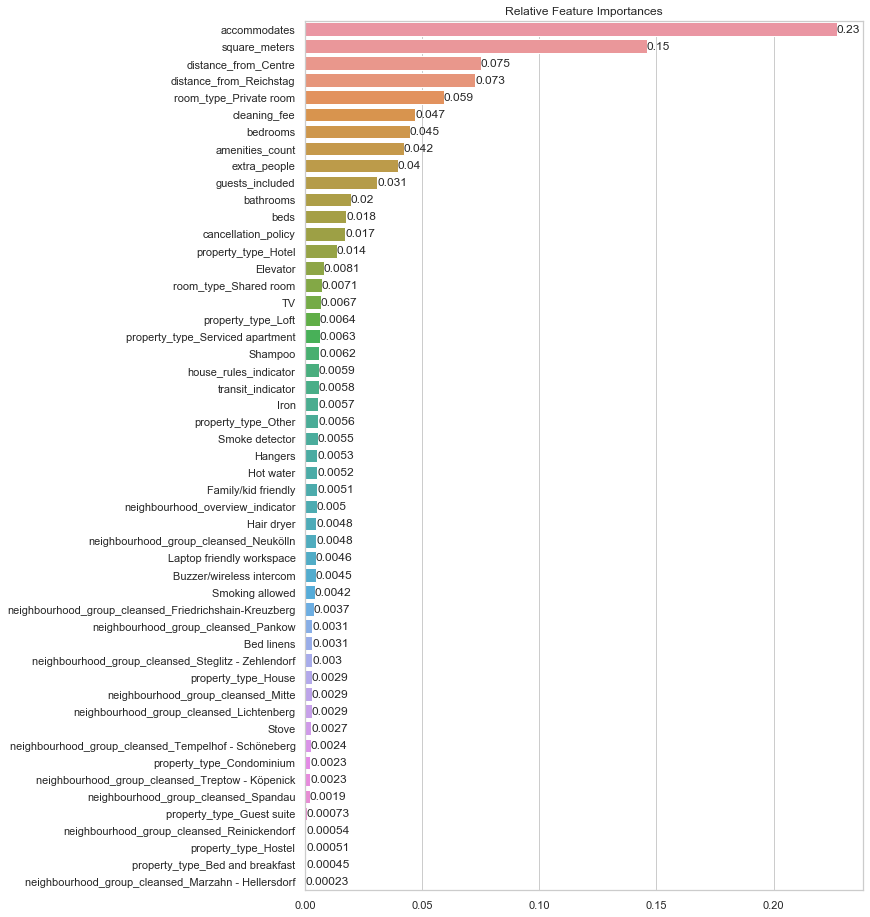

In [28]:
feature_importances = pd.Series(rfr.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,16))
ax = sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Relative Feature Importances')
for p in ax.patches:
    x = p.get_bbox().get_points()[1,0]
    y = p.get_bbox().get_points()[:,1]
    ax.annotate(f'{x:.2}', (x, y.mean()), ha='left', va='center')

Now we can test different thresholds for relative importance to see if the our results improve.

In [29]:
for threshold in [0.0025, 0.005, 0.0075, 0.01]:
    sfm = SelectFromModel(rfr, threshold=threshold)
    sfm.fit(X_train, y_train)

    X_important_train = sfm.transform(X_train)
    X_important_test = sfm.transform(X_test)

    rfr_important = RandomForestRegressor().fit(X_important_train, y_train)
    print('Relative Importance Threshold: ', threshold)
    generate_metrics(rfr_important, X_important_test, y_test)
    print('\n')

Relative Importance Threshold:  0.0025
MSE: 891.4999572530406
RMSE: 29.857996537829536
MAE: 17.458896469890238


Relative Importance Threshold:  0.005
MSE: 885.4417685404925
RMSE: 29.756373578453616
MAE: 17.394958469296945


Relative Importance Threshold:  0.0075
MSE: 907.4144909819045
RMSE: 30.123321380317684
MAE: 17.678243844556512


Relative Importance Threshold:  0.01
MSE: 911.0139291901513
RMSE: 30.18300729202031
MAE: 17.713174132304953




It looks like or results do improve when we use a subset of our features. The best threshold I tried looks to be 0.005. I will use this threshold to tune the parameters in the random forest model. First, lets create the subset of features.

In [36]:
sfm = SelectFromModel(rfr, threshold=0.005)
sfm.fit(X_train, y_train)

X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

Now we can do a randomised grid search to find parameters in our model for best performance. First, we will define our search parameters.

In [41]:
# Number of trees in forest
n_estimators = [int(x) for x in np.linspace(100, 1500, 15)]
# Max depth of trees
max_depth = [int(x) for x in np.linspace(10, 100, 10)]
max_depth.append(None)
# Minimum samples needed to split branch
min_samples_split = [2, 4, 8]
# Minimum samples required at each leaf node
min_samples_leaf = [1, 2, 3]

random_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
}

Now we can run our random search.

In [43]:
rfr = RandomForestRegressor()
rf_random = RandomizedSearchCV(
    estimator=rfr,
    param_distributions=random_grid,
    n_iter=100,
    cv=3,
    n_jobs=-1,
    verbose=2,
)
rf_random.fit(X_important_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 45.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 81.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [47]:
print('Model before randomised grid search:')
generate_metrics(rfr.fit(X_important_train, y_train), X_important_test, y_test)
print('\nModel after randomised grid search:')
generate_metrics(rf_random.best_estimator_, X_important_test, y_test)

Model before randomised grid search:
MSE: 901.1040049540196
RMSE: 30.018394443307916
MAE: 17.533171165826165

Model after randomised grid search:
MSE: 875.527712837538
RMSE: 29.589317545991797
MAE: 17.186649432325225


We have a small improvement, let's look what the best parameters were.

In [48]:
rf_random.best_params_

{'n_estimators': 1300,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_depth': 100}

Now we can do a more specific grid search to try and optimise the parameters in our model further.

In [51]:
n_estimators = [1200, 1300, 1400]
min_samples_split = [2, 4, 6]
min_samples_leaf = [1, 2, 3]
max_depth = [90, 100, 110, None]

grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
}

In [52]:
rfr = RandomForestRegressor()
grid_search = GridSearchCV(
    estimator=rfr,
    param_grid=grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
)
grid_search.fit(X_important_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 155.0min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 243.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [53]:
print('Randomised grid search model:')
generate_metrics(rf_random.best_estimator_, X_important_test, y_test)
print('\nGrid search model:')
generate_metrics(grid_search.best_estimator_, X_important_test, y_test)

Randomised grid search model:
MSE: 875.527712837538
RMSE: 29.589317545991797
MAE: 17.186649432325225

Grid search model:
MSE: 874.3188731721089
RMSE: 29.568883529347346
MAE: 17.17365270324996


We have a small improvement on our previous model. The optimal parameters were:

In [54]:
grid_search.best_params_

{'max_depth': 110,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 1300}

We can now plot the predictions against the actual prices of the listings using a scatterplot.

(0, 500)

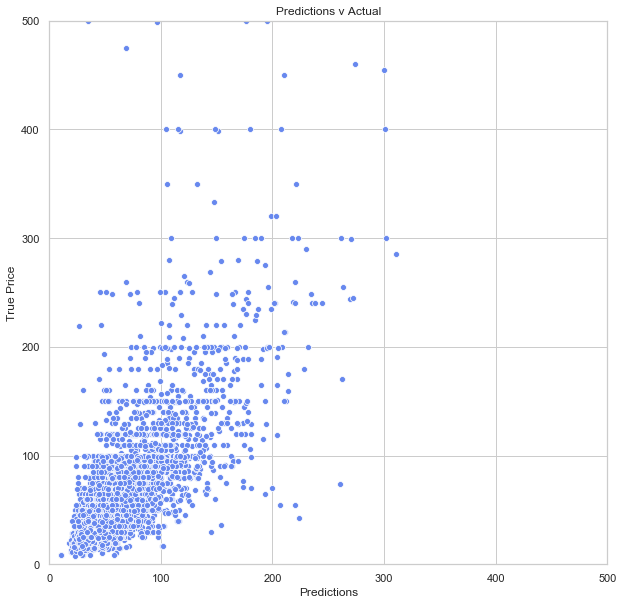

In [58]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=grid_search.predict(X_important_test), y=y_test)
plt.xlabel('Predictions')
plt.ylabel('True Price')
plt.title('Predictions v Actual')
plt.xlim((0, 500))
plt.ylim((0,500))

Our model seems to struggle with listings with higher prices, frequently underpredicting the price of the listing. This is likely due to there being a much smaller amount of training data for the listings with higher price. The model still doesn't perform to a degree of accuracy that would be particulary useful for a host though. This is due to the model missing information that would be useful, for example, the reputation of the listing or style could have a large influence on the price but we haven't accounted for this in our model. 